# **TIMIT Data set**

# **audio feature extraction and librosa Link**

In [1]:
!pip install -q kagglehub hmmlearn librosa numpy scikit-learn matplotlib

import os
import numpy as np
import librosa
import librosa.display
import kagglehub
from hmmlearn import hmm
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Downloading TIMIT...")
path = kagglehub.dataset_download("mfekadu/darpa-timit-acousticphonetic-continuous-speech")
print("Dataset ready at:", path)

wav_files = []
for root, _, files in os.walk(path):
    for f in files:
        if f.upper().endswith(".WAV"):
            wav_files.append(os.path.join(root, f))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 4.2 MB/s eta 0:00:00


100%|██████████| 829M/829M [00:07<00:00, 114MB/s]

Extracting files...


Dataset ready at: /root/.cache/kagglehub/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech/versions/6


In [7]:
print(f"Found {len(wav_files)} WAV files")
subset = wav_files[:50]
y, sr = librosa.load(subset[0], sr=None)

Found 12600 WAV files


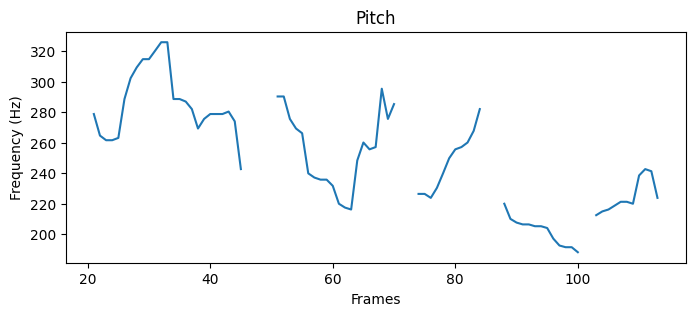

In [8]:
# https://librosa.org/doc/main/generated/librosa.pyin.html
def extract_pitch(y, sr):
    f0, voiced_flag, voiced_probs = librosa.pyin(y,

                                             sr=sr,

                                             fmin=librosa.note_to_hz('C2'),

                                             fmax=librosa.note_to_hz('C7'))

    times = librosa.times_like(f0, sr=sr)
    return f0
pitch = extract_pitch(y, sr)

plt.figure(figsize=(8,3))
plt.plot(pitch)
plt.title("Pitch")
plt.xlabel("Frames")
plt.ylabel("Frequency (Hz)")
plt.show()

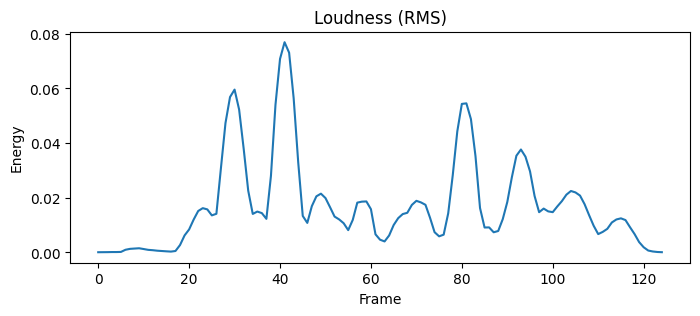

In [9]:
# https://librosa.org/doc/latest/generated/librosa.feature.rms.html
def extract_loudness(y):
    loudness = librosa.feature.rms(y=y)[0]
    return loudness
loudness = extract_loudness(y)
plt.figure(figsize=(8,3))
plt.plot(loudness)
plt.title("Loudness (RMS)")
plt.xlabel("Frame")
plt.ylabel("Energy")
plt.show()

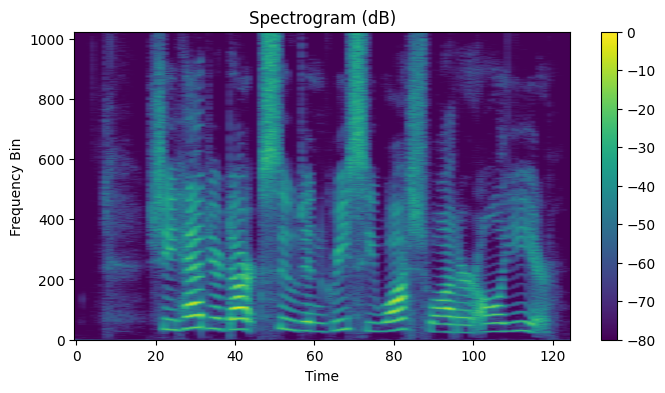

In [11]:
# https://librosa.org/doc/latest/generated/librosa.stft.html
def extract_spectrogram(y, sr):
    S = np.abs(librosa.stft(y))
    S_left = librosa.stft(y, center=False)
    D_short = librosa.stft(y, hop_length=64)
    D_db=librosa.amplitude_to_db(S,ref=np.max)
    return D_db
spec = extract_spectrogram(y,sr)
plt.figure(figsize=(8,4))
plt.imshow(spec, aspect='auto', origin='lower')
plt.title("Spectrogram (dB)")
plt.xlabel("Time")
plt.ylabel("Frequency Bin")
plt.colorbar()
plt.show()

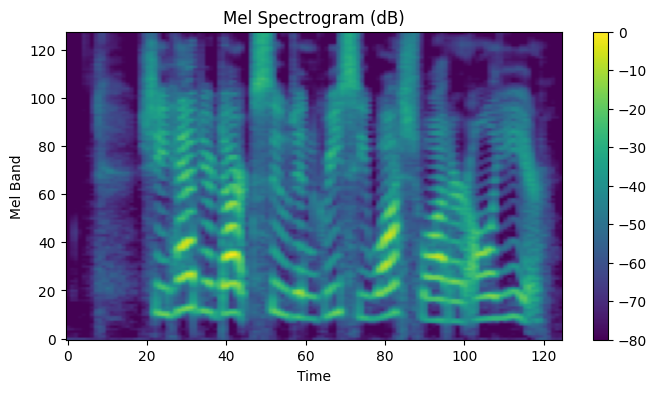

In [13]:
# https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
def extract_mel(y, sr):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_db = S_dB = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_db
mel_db=extract_mel(y, sr)
plt.figure(figsize=(8,4))
plt.imshow(mel_db, aspect='auto', origin='lower')
plt.title("Mel Spectrogram (dB)")
plt.xlabel("Time")
plt.ylabel("Mel Band")
plt.colorbar()
plt.show()

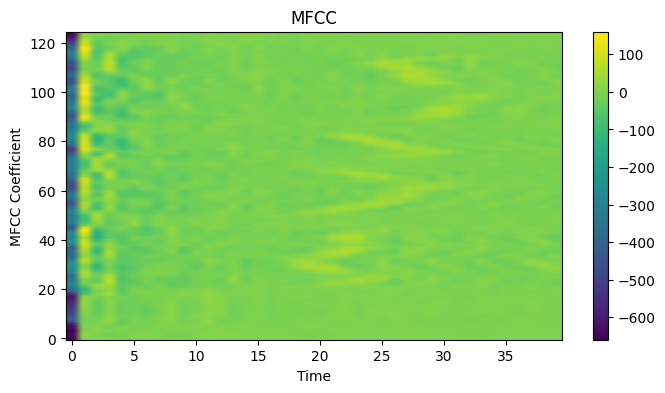

In [14]:
# https://librosa.org/doc/0.11.0/generated/librosa.feature.mfcc.html
def extract_mfcc(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfcc.T
mfcc=extract_mfcc(y, sr)
plt.figure(figsize=(8,4))
plt.imshow(mfcc, aspect='auto', origin='lower')
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficient")
plt.colorbar()
plt.show()

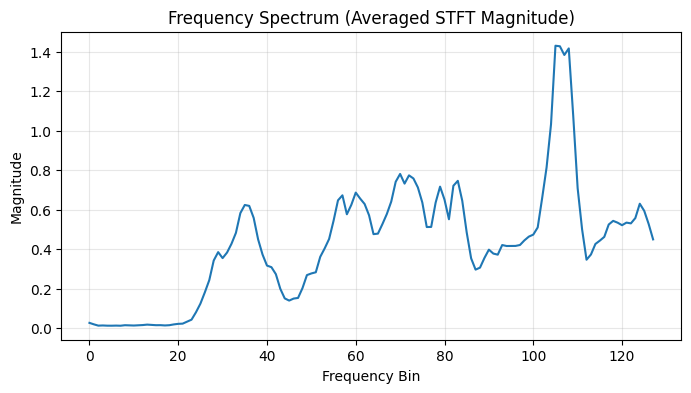

In [15]:
# https://librosa.org/doc/latest/generated/librosa.stft.html
def extract_frequency_spectrum(y, sr):
    S = np.abs(librosa.stft(y))
    spec = np.mean(S, axis=1)
    return spec[:128]
freq_spec = extract_frequency_spectrum(y, sr)
plt.figure(figsize=(8,4))
plt.plot(freq_spec)
plt.title("Frequency Spectrum (Averaged STFT Magnitude)")
plt.xlabel("Frequency Bin")
plt.ylabel("Magnitude")
plt.grid(True, alpha=0.3)
plt.show()

# **models "HMM forward","vertibi","ctc"**

In [18]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# دالة Gaussian probability
def gaussian_prob(obs, mean, covar):
    covar = covar + 1e-8
    diff = obs - mean
    exponent = -0.5 * np.sum(diff * diff / covar)
    denom = np.sqrt((2 * np.pi) ** len(obs) * np.prod(covar))
    return np.exp(exponent) / denom

In [20]:
def custom_forward(obs, pi, transmat, means, covars):
  t=len(obs)
  n=len(pi)
  alpha=np.zeros((t,n))
  for time  in range(t):
    for j in range(n):
      if time==0:
        alpha[0][j]=pi[j]*gaussian_prob(obs[0], means[j], covars[j])
      else:
        total = 0
        for i in range(n):
          total+=alpha[time-1][i]*transmat[i][j]
        alpha[time][j]=total*gaussian_prob(obs[time], means[j], covars[j])
  likelihood=np.sum(alpha[time-1,:])
  return likelihood, alpha


In [22]:
def vertibi(obs, pi, transmat, means, covars):
  t=len(obs)
  n=len(pi)
  alpha=np.zeros((t,n))
  psi = np.zeros((t, n), dtype=int)
  for time  in range(t):
    for j in range(n):
      if time==0:
        alpha[0][j]=pi[j]*gaussian_prob(obs[0], means[j], covars[j])
      else:
        total = 0
        maxx=0
        for i in range(n):
          best_prev=0
          total=alpha[time-1][i]*transmat[i][j]
          if total >maxx:
            maxx=total
            best_prev =i

        alpha[time][j]=maxx*gaussian_prob(obs[time], means[j], covars[j])
        psi[time, j] = best_prev
  best_score=np.max(alpha[t-1,:])
  best_path_end=np.argmax(alpha[t-1,:])
  path = [best_path_end]
  for time in range(t-1, 0, -1):
    path.insert(0, psi[time, path[0]])

    return path, best_score, alpha


Forward likelihood: 0.0
Viterbi score: 0.0
Best final state: [np.int64(0), np.int64(0)]


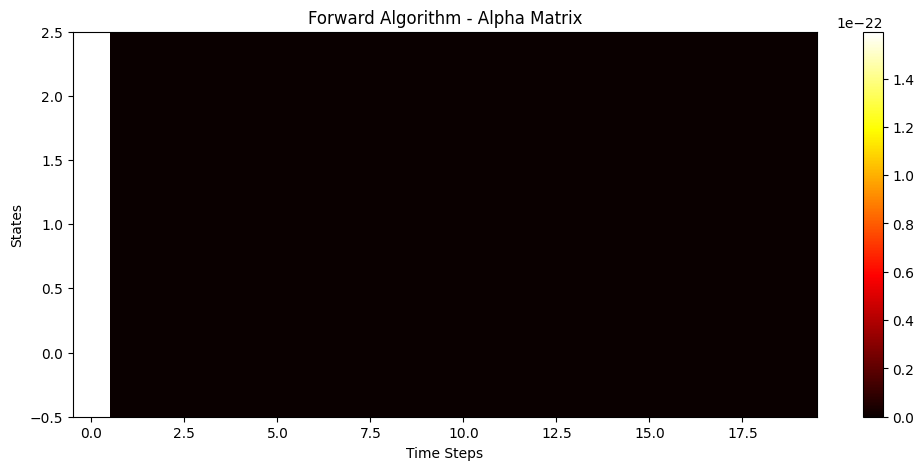

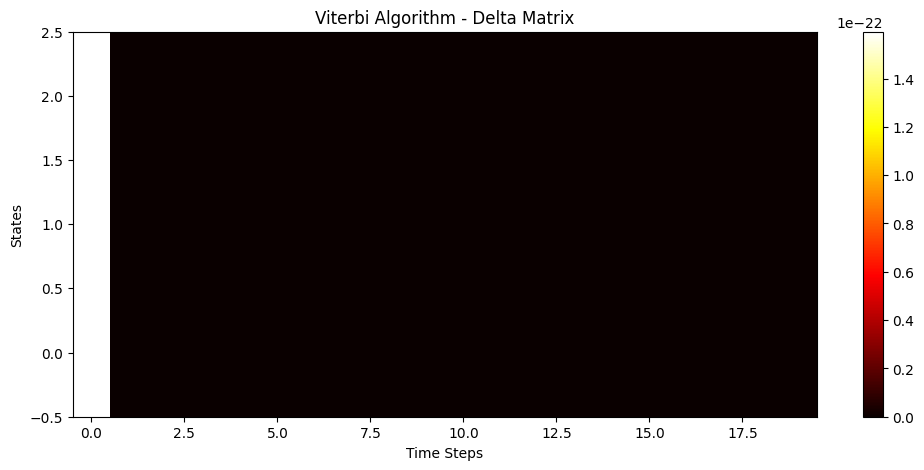

In [23]:






# ===== استخراج MFCC لأول صوت في subset =====
file = subset[0]
y, sr = librosa.load(file, sr=None)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T  # time × 13

# نستخدم الـ MFCC كـ observation
obs = mfcc[:20]  # مثال: أول 20 إطار

# افتراضياً: إنشاء HMM بسيط
n_states = 3
obs_dim = obs.shape[1]

pi = np.full(n_states, 1/n_states)
transmat = np.full((n_states, n_states), 1/n_states)

mean_obs = np.mean(obs, axis=0)   # shape (13,)
var_obs = np.var(obs, axis=0)     # shape (13,)

# إنشاء means لكل حالة HMM
means = np.array([mean_obs + np.random.rand(obs_dim)*0.01 for _ in range(n_states)])
covars = np.array([var_obs + 1e-2 for _ in range(n_states)])

# ==== Forward ====
forward_score, alpha = custom_forward(obs, pi, transmat, means, covars)
print("Forward likelihood:", forward_score)

# ==== Viterbi ====
best_end, viterbi_score, delta = vertibi(obs, pi, transmat, means, covars)
print("Viterbi score:", viterbi_score)
print("Best final state:", best_end)

# ==== Plots ====
plt.figure(figsize=(12,5))
plt.imshow(alpha.T, aspect='auto', origin='lower', cmap='hot')
plt.title("Forward Algorithm - Alpha Matrix")
plt.xlabel("Time Steps")
plt.ylabel("States")
plt.colorbar()
plt.show()

plt.figure(figsize=(12,5))
plt.imshow(delta.T, aspect='auto', origin='lower', cmap='hot')
plt.title("Viterbi Algorithm - Delta Matrix")
plt.xlabel("Time Steps")
plt.ylabel("States")
plt.colorbar()
plt.show()
